# Change directory to wherever you are housing this project

In [1]:
import sys
sys.path.append("C:/Users/ahaberlie/Documents/GitHub/MCS/")

# Download example radar data

Download data.tar.gz from https://tiny.cc/ + the full manuscript ID for part 1 (case sensitive), and untar and ungzip this into the directory "MCS/mcs" and make sure the output folder is "data" and it has a folder named "radar_data". Examine the code to see the proper location if you are getting an error (i.e., "../data/radar_data/")

In [2]:
import numpy as np
from scipy.misc import imread
import warnings
warnings.filterwarnings("ignore")

# Set up plotting utilities and values

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from mcs.utils.colors import radar_colormap
import matplotlib.patheffects as pe

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 10

cmap = radar_colormap()
classes = list(range(0, 80, 5))
norm = BoundaryNorm(classes, ncolors=cmap.N, clip=True)

# Set up mapping utilities

In [4]:
import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

from_proj = ccrs.PlateCarree()
to_proj = ccrs.AlbersEqualArea(central_longitude=-95, central_latitude=38.0000)

def draw_states(ax):
    
    shapename = 'admin_1_states_provinces_lakes_shp'
    states_shp = shpreader.natural_earth(resolution='50m',
                                     category='cultural', name=shapename)

    for state, info in zip(shpreader.Reader(states_shp).geometries(), shpreader.Reader(states_shp).records()):
        if info.attributes['admin'] == 'United States of America':

            ax.add_geometries([state], ccrs.PlateCarree(),
                              facecolor='None', edgecolor='k')

# Get lat/lon coordinates for radar data

In [5]:
from mcs.utils.mapping_help import *

lons, lats = get_NOWrad_conus_lon_lat()

lons, lats = np.meshgrid(lons, lats)

# Plot radar image

Text(0.5,1,'Reflectivity valid at 1100 UTC on 7 May 1997')

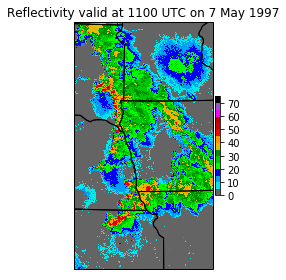

In [6]:
img = imread("../data/radar_data/BREF_970507_1100.png", mode='P')
to_proj = ccrs.AlbersEqualArea(central_longitude=-95, central_latitude=38.0000)
ax = plt.subplot(2, 2, 1, projection=to_proj)

ax.set_extent([-98.5, -92.5, 38.1, 46])

draw_states(ax)

mmp = ax.pcolormesh(lons, lats, img*5, cmap=cmap, norm=norm, transform=from_proj)

plt.colorbar(mmp, ax=ax, shrink=0.4, pad=0.01)

plt.title("Reflectivity valid at 1100 UTC on 7 May 1997")

# Slice segmentation

Set convective region search radius (CRSR) to 24 km

Set stratiform search radius (SSR) to 96 km

(See function documentation for more details on the following value conversions)

In [7]:
from mcs.utils.segmentation import *

conv_buffer = 4  # 4 * 2 * 3 = 24 km
strat_buffer = 16 # 16 * 2 * 3 = 96 km

Find pixels associated with intense deep convective cells

In [8]:
intense_cells = get_intense_cells(img)

Merge intense cells within a given radius

In [9]:
merged_lines = connect_intense_cells(intense_cells, conv_buffer)

long_lines = find_lines(img, conv_buffer)

Connect stratiform pixels to merged lines within a given radius

In [10]:
stratiform_merge = connect_stratiform_to_lines(find_lines(img, conv_buffer), img>=4, strat_buffer)

# Illustration of each step

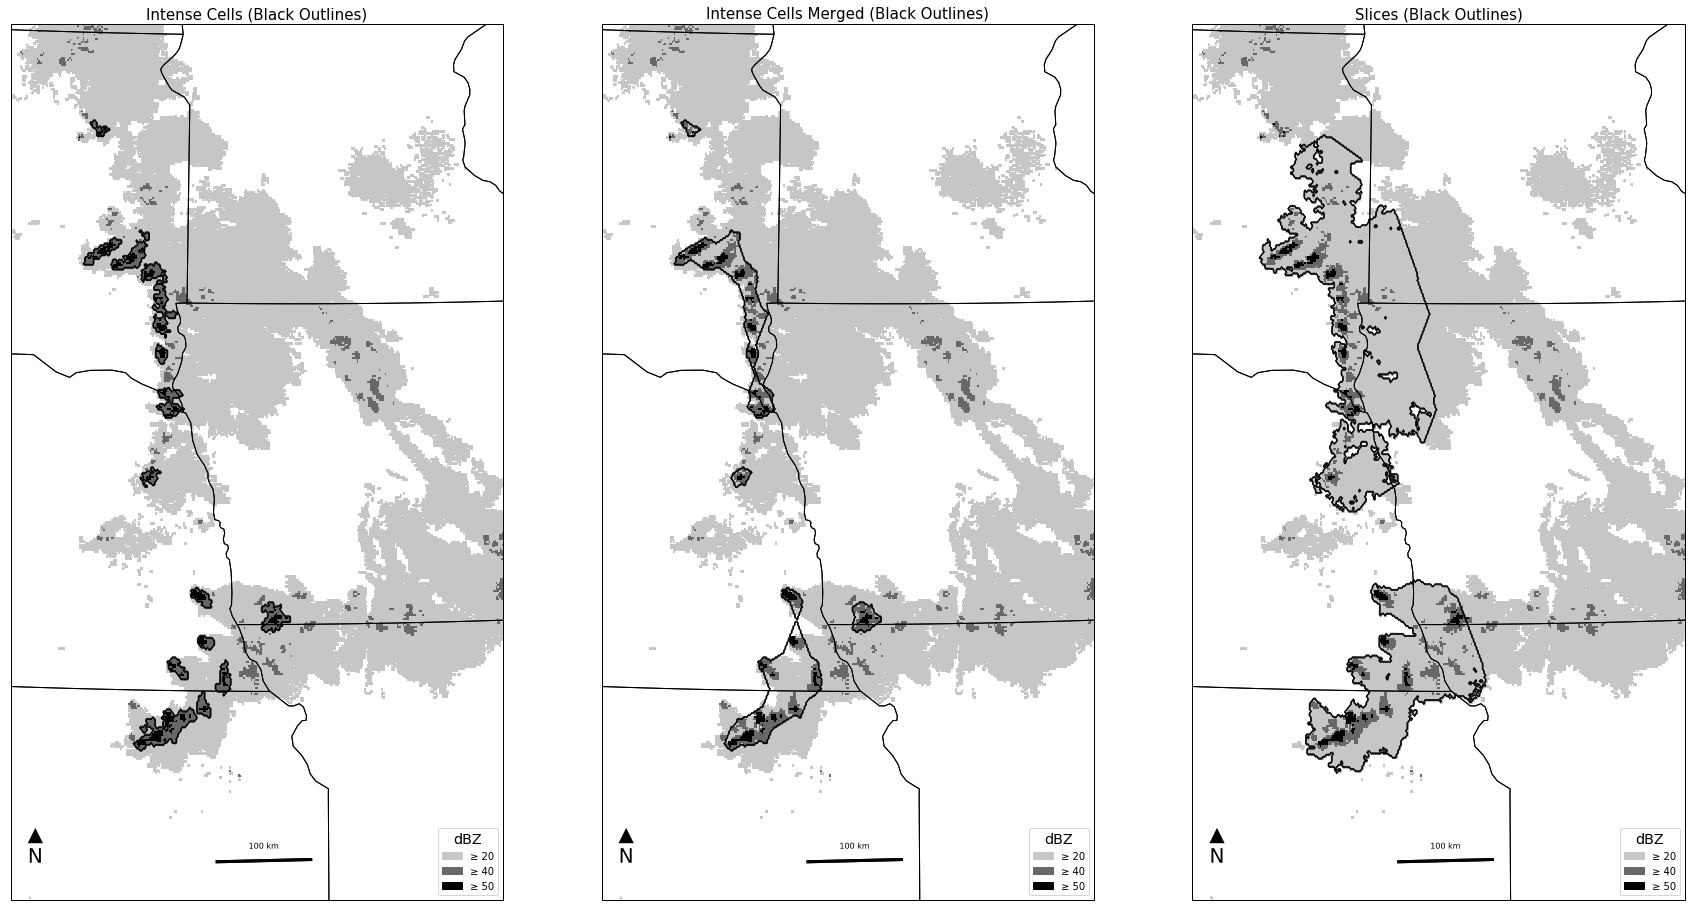

In [11]:
img1 = np.ma.masked_where(img < 4, img)

plt.rcParams['figure.figsize'] = 30, 30

to_proj = ccrs.AlbersEqualArea(central_longitude=-95, central_latitude=38.0000)

titles = ['Intense Cells (Black Outlines)', 'Intense Cells Merged (Black Outlines)', 'Slices (Black Outlines)']

for i, data in enumerate([intense_cells, merged_lines, stratiform_merge]):

    ax = plt.subplot(1, 3, i+1, projection=to_proj)
    ax.set_extent([-98.5, -92.5, 38.1, 46])

    ax.pcolormesh(lons, lats, quantize(img1), vmin=0, vmax=3, cmap='Greys', transform=from_proj)
    ax.contour(lons, lats, 1*(data>0), colors=['k',], linewidths=.5, linestyles='solid', transform=from_proj, zorder=5)
    
    draw_states(ax)
    scale_bar(ax, to_proj, 100)

    leg = ax.legend([mpatches.Patch(color=plt.cm.Greys(1/3)),  
                                    mpatches.Patch(color=plt.cm.Greys(2/3)), 
                                    mpatches.Patch(color=plt.cm.Greys(3/3))], 
                                    ['≥ 20','≥ 40','≥ 50'], loc=4)
    
    ax.set_title(titles[i], fontsize=15)
    leg.set_title("dBZ", prop = {'size':'x-large'})

# Absurd example

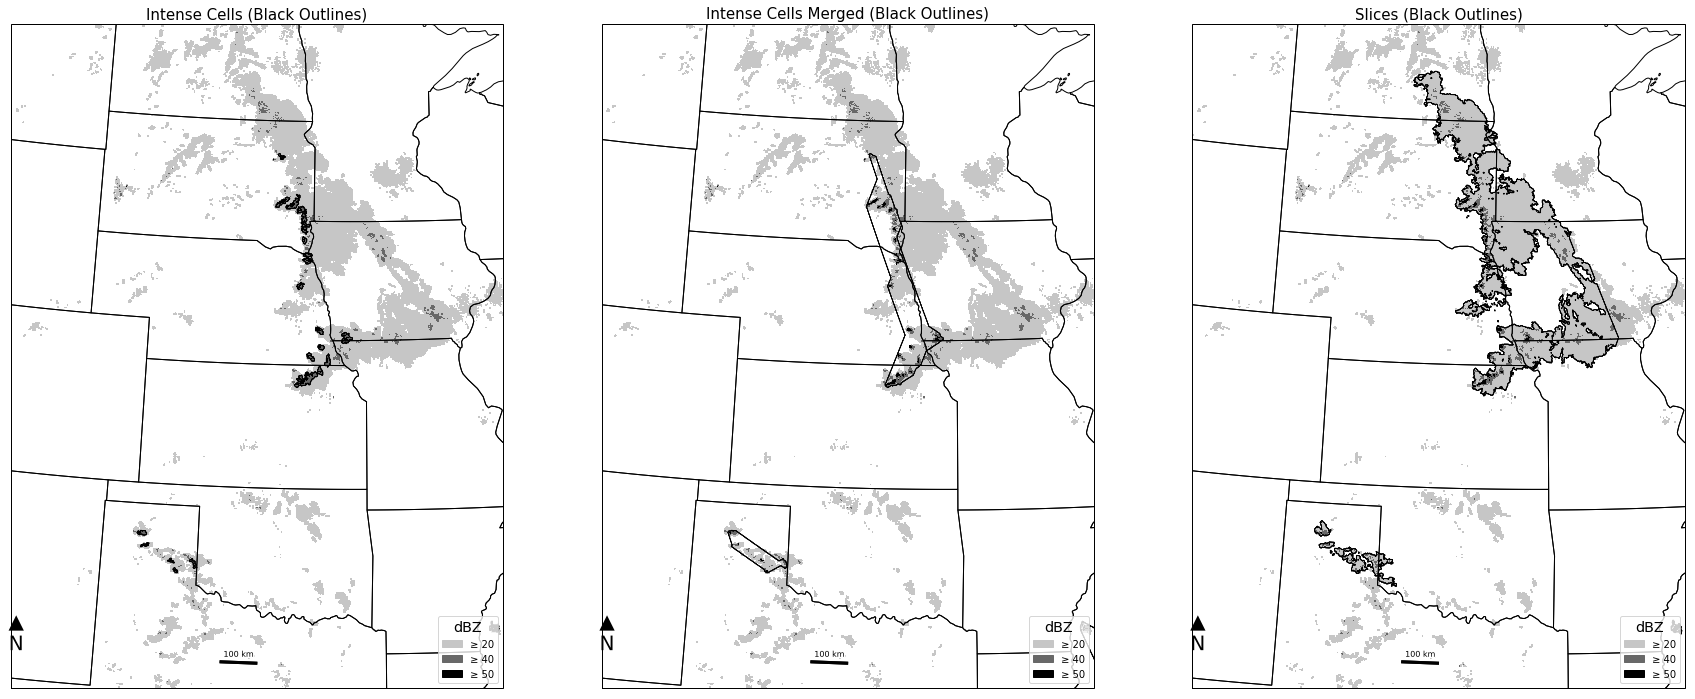

In [12]:
conv_buffer = 50  # 50 * 2 * 3 = 300 km
strat_buffer = 50 # 50 * 2 * 3 = 300 km
intense_cells = get_intense_cells(img)
merged_lines = connect_intense_cells(intense_cells, conv_buffer)

long_lines = find_lines(img, conv_buffer)
stratiform_merge = connect_stratiform_to_lines(find_lines(img, conv_buffer), img>=4, strat_buffer)

img1 = np.ma.masked_where(img < 4, img)

plt.rcParams['figure.figsize'] = 30, 30

to_proj = ccrs.AlbersEqualArea(central_longitude=-95, central_latitude=38.0000)

titles = ['Intense Cells (Black Outlines)', 'Intense Cells Merged (Black Outlines)', 'Slices (Black Outlines)']

for i, data in enumerate([intense_cells, merged_lines, stratiform_merge]):

    ax = plt.subplot(1, 3, i+1, projection=to_proj)
    ax.set_extent([-105.5, -90.5, 32.1, 48])

    ax.pcolormesh(lons, lats, quantize(img1), vmin=0, vmax=3, cmap='Greys', transform=from_proj)
    ax.contour(lons, lats, 1*(data>0), colors=['k',], linewidths=.5, linestyles='solid', transform=from_proj, zorder=5)
    
    draw_states(ax)
    scale_bar(ax, to_proj, 100)

    leg = ax.legend([mpatches.Patch(color=plt.cm.Greys(1/3)),  
                                    mpatches.Patch(color=plt.cm.Greys(2/3)), 
                                    mpatches.Patch(color=plt.cm.Greys(3/3))], 
                                    ['≥ 20','≥ 40','≥ 50'], loc=4)
    
    ax.set_title(titles[i], fontsize=15)
    leg.set_title("dBZ", prop = {'size':'x-large'})